## Imports and definitions

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [12]:
path = "data/"
sz = 256
bs = 64
arch = wrn_50_2f

## Submission definition

In [13]:
def submit_predictions(learner, is_tta=True):
    if is_tta:
        log_probs,_ = learner.TTA(is_test=True)
        probs = np.exp(log_probs)
        probs = np.mean(probs, axis=0)
    else:
        log_probs = learn.predict(is_test=True)
        probs = np.exp(log_probs)
    probs = np.clip(probs, 0.0001, 0.9999)
    test_fnames = data.test_dl.dataset.fnames
    test_ids = list(map(lambda x: re.split('/|\.',x)[1], test_fnames))
    probs_flattened = probs.flatten()
    probs_formatted = np.array(list(map(lambda x: '%0.6f'%x, probs_flattened)))
    probs_formatted = np.reshape(probs_formatted, probs.shape)
    result = list(map(lambda x: [test_ids[x]] + list(probs_formatted[x]), range(len(test_ids))))
    
    result_file = "./data/results/result.csv"
    header = ','.join(['id']+data.classes)
    np.savetxt(result_file, result, delimiter=',', comments='', fmt='%s', header=header)
    !kg submit {result_file}

## Validation data split

In [14]:
label_csv = f'{path}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n, val_pct=0.15)

In [15]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path, 'train', label_csv, test_name='test', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz < 300 else data.resize(300,'tmp')

## Model Training

In [16]:
data = get_data(sz, bs)

In [18]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

TypeError: wrn_50_2f() takes 0 positional arguments but 1 was given

In [9]:
learn.get_layer_groups()

[Sequential(
   (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)
   (1): Dropout(p=0.5)
   (2): Linear(in_features=4096, out_features=1000)
   (3): ReLU()
   (4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
   (5): Dropout(p=0.5)
   (6): Linear(in_features=1000, out_features=500)
   (7): ReLU()
   (8): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
   (9): Dropout(p=0.5)
   (10): Linear(in_features=500, out_features=120)
   (11): LogSoftmax()
 )]

### Train with precomputed layers

In [12]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 128/136 [02:15<00:08,  1.06s/it, loss=16.5]

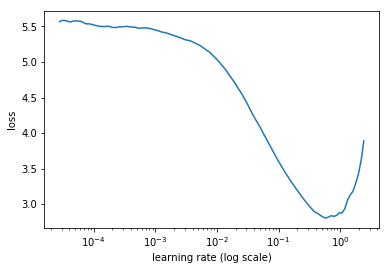

In [13]:
learn.sched.plot()

In [14]:
learn.fit(0.1, 2, cycle_len=5)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

  5%|▌         | 7/136 [00:08<02:33,  1.19s/it, loss=5.63]  


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.066299   0.390761   0.888544  
    1      0.502528   0.300384   0.906122                    
    2      0.308599   0.248794   0.92116                     
    3      0.222028   0.218482   0.931545                    
    4      0.18265    0.218516   0.929623                    
    5      0.273334   0.282937   0.921096                    
    6      0.227507   0.269641   0.919239                    
    7      0.185599   0.229809   0.929004                    
    8      0.137941   0.21187    0.937436                    
    9      0.134305   0.212391   0.932847                    



[0.21239096, 0.9328466529647509]

In [16]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 120/136 [02:08<00:17,  1.07s/it, loss=0.493]

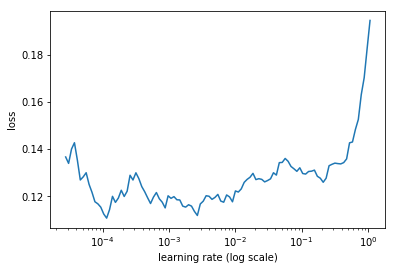

In [17]:
learn.sched.plot()

In [18]:
learn.fit(0.001, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  0%|          | 0/136 [00:00<?, ?it/s]                      


Exception in thread Thread-18:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.128119   0.208425   0.9348    
    1      0.136269   0.211101   0.933498                    



[0.21110141, 0.9334976946314176]

In [19]:
submit_predictions(learn)

0.21561                                       


### Train with data augmentation

In [20]:
learn.precompute = False

In [21]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 90%|████████▉ | 122/136 [02:09<00:14,  1.06s/it, loss=0.561]

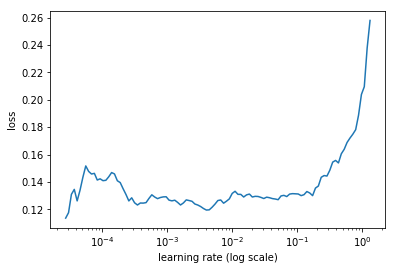

In [22]:
learn.sched.plot()

In [ ]:
learn.fit(0.1, 2, cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

  5%|▌         | 7/136 [00:08<02:34,  1.20s/it, loss=0.127]  


Exception in thread Thread-22:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.179438   0.261095   0.921779  
 21%|██        | 28/136 [00:30<01:58,  1.10s/it, loss=0.171]

In [ ]:
submit_predictions(learn)

## Learn with larger dataset

In [20]:
data299 = get_data(299, bs)
learn.set_data(data299)
learn.freeze()

In [21]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 90%|█████████ | 123/136 [03:07<00:19,  1.53s/it, loss=0.835]

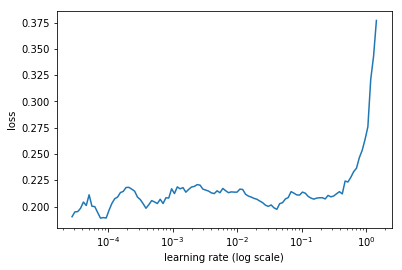

In [23]:
learn.sched.plot()

In [25]:
learn.fit(0.01, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.172265   0.226959   0.926987  



[0.22695875, 0.9269872779647509]

In [ ]:
submit_predictions(learn)

 25%|██▌       | 1/4 [03:48<11:25, 228.64s/it]